# Assignment V — Graph Neural Networks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, datetime, pathlib

# Change this folder name if you want
PROJECT_DIR = "/content/drive/MyDrive/Assignment_5"
RUN_DATE = datetime.datetime.now().strftime("%Y-%m-%d")
OUT_DIR = os.path.join(PROJECT_DIR, "outputs", RUN_DATE)

FIG_DIR = os.path.join(OUT_DIR, "figures")
TAB_DIR = os.path.join(OUT_DIR, "tables")
CKPT_DIR = os.path.join(OUT_DIR, "checkpoints")

for d in [PROJECT_DIR, OUT_DIR, FIG_DIR, TAB_DIR, CKPT_DIR]:
    pathlib.Path(d).mkdir(parents=True, exist_ok=True)

print("Project folder:", PROJECT_DIR)
print("Output folder:", OUT_DIR)
print("Figures ->", FIG_DIR)
print("Tables  ->", TAB_DIR)
print("Models  ->", CKPT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project folder: /content/drive/MyDrive/Assignment_5
Output folder: /content/drive/MyDrive/Assignment_5/outputs/2026-01-21
Figures -> /content/drive/MyDrive/Assignment_5/outputs/2026-01-21/figures
Tables  -> /content/drive/MyDrive/Assignment_5/outputs/2026-01-21/tables
Models  -> /content/drive/MyDrive/Assignment_5/outputs/2026-01-21/checkpoints


Install libraries + import everything we need

Graph Neural Networks (GNNs) usually use:
- **PyTorch** for neural networks
- **PyTorch Geometric (PyG)** for graph datasets, graph layers, and utilities
- **pandas/numpy** for table + numeric work
- **matplotlib/seaborn** for graphs
- **sklearn** for basic metrics and splitting


In [ ]:
# --- Install PyTorch Geometric (PyG) (safe to run in Colab) ---
!pip -q install torch-geometric

# --- Core imports ---
import os
import pathlib
import datetime
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# PyG (Graph Neural Network utilities)
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected

# --- Make plots look nicer ---
sns.set(style="whitegrid")

# --- Reproducibility: set seeds so results are more stable ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.7 MB/s eta 0:00:00
Using device: cpu


 Load the datasets (CSV files)

We load the data into **pandas DataFrames** so we can:
- inspect columns and missing values
- build the graph (nodes + edges) in Task 1
- create features and the target variable (fansub count)

We also print shapes + column names because it helps catch common problems early:
- wrong file loaded
- unexpected column names
- empty / corrupted files

In [ ]:
# File paths (you already confirmed these are in /content)
anime_path   = "/content/anime_data.csv"
creator_path = "/content/creators.csv"
genres_path  = "/content/genres.csv"
subs_path    = "/content/subs_eng.csv"

# Load CSVs
anime_df   = pd.read_csv(anime_path)
creators_df = pd.read_csv(creator_path)
genres_df  = pd.read_csv(genres_path)
subs_df    = pd.read_csv(subs_path)

# Quick checks (student-friendly “sanity check”)
print("anime_df shape:", anime_df.shape)
print("creators_df shape:", creators_df.shape)
print("genres_df shape:", genres_df.shape)
print("subs_df shape:", subs_df.shape)

print("\n--- Columns ---")
print("anime_df columns:", list(anime_df.columns))
print("creators_df columns:", list(creators_df.columns))
print("genres_df columns:", list(genres_df.columns))
print("subs_df columns:", list(subs_df.columns))

# Show a few rows from each so we understand what's inside
display(anime_df.head(3))
display(creators_df.head(3))
display(genres_df.head(3))
display(subs_df.head(3))

anime_df shape: (1895, 16)
creators_df shape: (24560, 2)
genres_df shape: (44508, 3)
subs_df shape: (23387, 6)

--- Columns ---
anime_df columns: ['anime_id', 'main_title', 'descript', 'aired_year', 'aired_from', 'top_home_sales', 'awards', 'num_creators', 'num_genres', 'num_subs_eng', 'num_subs_for', 'license_date', 'median_rank', 'best_rank', 'top_1000_days', 'top_10000_days']
creators_df columns: ['anime_id', 'creator_id']
genres_df columns: ['anime_id', 'genre_id', 'genre_label']
subs_df columns: ['anime_id', 'group_id', 'sub_year', 'first_upload', 'complete', 'pre_license']


,anime_id,main_title,descript,aired_year,aired_from,top_home_sales,awards,num_creators,num_genres,num_subs_eng,num_subs_for,license_date,median_rank,best_rank,top_1000_days,top_10000_days
0,1,Seikai no Monshou,Based on the sci-fi novel series by Morioka Hi...,1999,1999-01-03,1,0,15,28,24,10,2001-06-05,53181.0,1003.0,0.0,193.0
1,4,Seikai no Senki,Based on the sci-fi novel series by Morioka Hi...,2000,2000-04-14,1,1,15,25,21,8,2003-01-21,54908.0,129.0,3.0,178.0
2,5,Seikai no Senki II,Based on the Seikai no Senki sci-fi novel seri...,2001,2001-07-11,1,1,15,31,12,11,2003-08-19,247689.0,14966.0,0.0,0.0


,anime_id,creator_id
0,1,12
1,1,39
2,1,139


,anime_id,genre_id,genre_label
0,1,36,military
1,1,2008,small breasts
2,1,2619,gunfights


,anime_id,group_id,sub_year,first_upload,complete,pre_license
0,1,1,2002,2002-04-21,1,0.0
1,1,26,2002,2002-08-24,1,0.0
2,1,34,2003,2003-08-27,1,0.0


### Task 1 — Step 1: Build the graph (edges)

A Graph Neural Network needs:
- **Nodes**: here, each node is an **anime**
- **Edges**: connections between animes that are "related"

We *create edges* using the idea:
- if two anime share a **creator**, they are related
- if two anime share a **genre**, they are related

This gives us an **anime–anime graph** that a GNN can learn from.

Why this is useful:
- An anime’s fansub count may be similar to other anime with similar creators/genres.
- The GNN learns by passing information across these edges.

In [ ]:
from collections import defaultdict
from itertools import combinations

# 1) List of anime ids we will use as nodes
anime_ids = anime_df["anime_id"].unique()
anime_ids = np.sort(anime_ids)

# Map anime_id -> node index (0..N-1) because PyG expects indices
anime_id_to_idx = {aid: i for i, aid in enumerate(anime_ids)}
idx_to_anime_id = {i: aid for aid, i in anime_id_to_idx.items()}

print("Number of anime nodes:", len(anime_ids))

# 2) Helper function to create anime-anime edges based on shared "thing" (creator or genre)
def build_edges_from_shared_column(df, anime_col, shared_col):
    """
    df: a DataFrame like creators_df or genres_df
    anime_col: name of anime id column ("anime_id")
    shared_col: name of shared entity column ("creator_id" or "genre_id")

    Returns: a set of (src_idx, dst_idx) edges between anime nodes
    """
    # group shared_id -> list of anime_ids that have it
    groups = df.groupby(shared_col)[anime_col].apply(list)

    edge_set = set()

    for shared_id, animes in groups.items():
        # remove duplicates just in case
        animes = list(set(animes))

        # if only 0 or 1 anime has this shared_id, it creates no edges
        if len(animes) < 2:
            continue

        # create all pairs among these animes
        for a1, a2 in combinations(animes, 2):
            # only keep if both anime are in our anime list
            if a1 in anime_id_to_idx and a2 in anime_id_to_idx:
                i = anime_id_to_idx[a1]
                j = anime_id_to_idx[a2]
                edge_set.add((i, j))
                edge_set.add((j, i))  # make it undirected by adding both directions

    return edge_set

# 3) Build edges from creators and genres
edges_creator = build_edges_from_shared_column(creators_df, "anime_id", "creator_id")
edges_genre   = build_edges_from_shared_column(genres_df, "anime_id", "genre_id")

# Combine edges
edges_all = edges_creator.union(edges_genre)

print("Edges from shared creators:", len(edges_creator))
print("Edges from shared genres:", len(edges_genre))
print("Total combined edges:", len(edges_all))

# 4) Convert edges to PyTorch tensor edge_index (shape [2, num_edges])
edge_index = torch.tensor(list(edges_all), dtype=torch.long).t().contiguous()

print("edge_index shape:", edge_index.shape)  # should be [2, E]

Number of anime nodes: 1895
Edges from shared creators: 395748
Edges from shared genres: 2548548
Total combined edges: 2583234
edge_index shape: torch.Size([2, 2583234])


### Task 1 — Step 2: Create node features (X) and target (y)

A GNN needs each node to have **features** (numbers) it can learn from.

- **X (features)**: we will use numeric columns from `anime_df` such as
  `aired_year`, `top_home_sales`, `awards`, `num_creators`, `num_genres`, etc.

We DO NOT use text columns like `main_title` or `descript` yet because a basic GNN
model expects numeric inputs (we could do text embeddings later, but not for a baseline).

- **y (label/target)**: for Task 1 we want to predict **fansub count**
  → we use `num_subs_eng`.

We also:
- sort the rows to match the node order (anime_id → node index)
- fill missing values with 0 (simple baseline)
- standardize (normalize) features so training is easier and more stable

In [ ]:
# 1) Put anime_df in the same order as our node list (anime_ids)
anime_nodes_df = anime_df.set_index("anime_id").loc[anime_ids].reset_index()

# 2) Choose target
target_col = "num_subs_eng"
y = anime_nodes_df[target_col].astype(float).values

# 3) Choose numeric feature columns (drop text + drop target)
# We'll automatically select numeric columns, then remove the target.
numeric_cols = anime_nodes_df.select_dtypes(include=[np.number]).columns.tolist()

# Remove columns we do NOT want as features:
# - anime_id is just an identifier (not useful as a feature)
# - target_col must not be inside X
for col_to_remove in ["anime_id", target_col]:
    if col_to_remove in numeric_cols:
        numeric_cols.remove(col_to_remove)

print("Numeric feature columns used for X:")
print(numeric_cols)

# 4) Build X matrix
X = anime_nodes_df[numeric_cols].copy()

# Fill missing values (baseline choice)
X = X.fillna(0)

# 5) Normalize features (z-score): (x - mean) / std
# This helps training because features are on similar scales.
X_mean = X.mean()
X_std = X.std().replace(0, 1)   # avoid divide-by-zero
X_norm = (X - X_mean) / X_std

# 6) Convert to torch tensors
x_tensor = torch.tensor(X_norm.values, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.float).view(-1, 1)  # shape [N, 1]

print("\nX shape:", x_tensor.shape)
print("y shape:", y_tensor.shape)
print("y (fansub count) basic stats:")
print("  min:", float(y_tensor.min()), "max:", float(y_tensor.max()), "mean:", float(y_tensor.mean()))

Numeric feature columns used for X:
['aired_year', 'top_home_sales', 'awards', 'num_creators', 'num_genres', 'num_subs_for', 'median_rank', 'best_rank', 'top_1000_days', 'top_10000_days']

X shape: torch.Size([1895, 10])
y shape: torch.Size([1895, 1])
y (fansub count) basic stats:
  min: 0.0 max: 91.0 mean: 12.341424942016602


### Task 1 — Step 3: Create the PyG graph object + train/val/test masks

PyTorch Geometric uses a `Data` object to store the graph:
- `data.x` = node features (X)
- `data.edge_index` = edges (connections)
- `data.y` = target values (fansub count)

For supervised learning we also need to split nodes into:
- **train**: nodes the model learns from
- **val**: nodes used to tune and check during training
- **test**: nodes used only at the end to report final performance

We use boolean masks (`train_mask`, `val_mask`, `test_mask`) because
PyG often trains on graphs where all nodes are in one object.

In [ ]:
# 1) Build Data object
data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)

# 2) Create train/val/test masks (node-level prediction)
N = data.num_nodes

# We'll do 70% train, 15% val, 15% test
all_idx = np.arange(N)

train_idx, temp_idx = train_test_split(all_idx, test_size=0.30, random_state=SEED)
val_idx, test_idx   = train_test_split(temp_idx, test_size=0.50, random_state=SEED)

train_mask = torch.zeros(N, dtype=torch.bool)
val_mask   = torch.zeros(N, dtype=torch.bool)
test_mask  = torch.zeros(N, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx]     = True
test_mask[test_idx]   = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print("Data object created!")
print("Num nodes:", data.num_nodes)
print("Num edges:", data.num_edges)
print("Num node features:", data.num_node_features)

print("\nSplit sizes:")
print("Train:", int(data.train_mask.sum()))
print("Val:  ", int(data.val_mask.sum()))
print("Test: ", int(data.test_mask.sum()))

# Move to GPU if available
data = data.to(DEVICE)
print("\nData moved to:", DEVICE)

Data object created!
Num nodes: 1895
Num edges: 2583234
Num node features: 10

Split sizes:
Train: 1326
Val:   284
Test:  285

Data moved to: cpu


### Task 1 — Step 4: Build a GNN model (GCN) for regression

We are predicting a **number** (fansub count), so this is a **regression** problem.

Model idea:
1. Use a GNN layer to let each anime "look at" its neighbors (related anime).
2. Use another GNN layer to learn deeper graph patterns.
3. Use a final linear layer to output **one number per node**.

We also use:
- **ReLU** activation to add non-linearity (helps learning complex patterns)
- **Dropout** to reduce overfitting

In [ ]:
from torch_geometric.nn import GCNConv

class GCNRegressor(nn.Module):
    def __init__(self, in_channels, hidden_channels=64, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 1)
        self.dropout = dropout

    def forward(self, x, edge_index):
        # GCN layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # GCN layer 2
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Output layer (predict one value per node)
        out = self.lin(x)
        return out

model = GCNRegressor(in_channels=data.num_node_features, hidden_channels=64, dropout=0.3).to(DEVICE)
print(model)

GCNRegressor(
  (conv1): GCNConv(10, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


### Task 1 — Step 5: Train the GNN (and validate while training)

We need 3 main pieces to train:

1. **Loss function**: tells the model how wrong it is.
   - Since this is regression, we use **MSE (Mean Squared Error)**.
   - MSE punishes big mistakes more than small mistakes.

2. **Optimizer**: updates model weights to reduce the loss.
   - We use **Adam** because it usually works well without lots of tuning.

3. **Training loop**:
   - Train on `train_mask`
   - Check performance on `val_mask`
   - Keep track of losses so we can plot/understand learning

We also compute:
- **MAE** (Mean Absolute Error): easier to interpret (“average error in fansub count”)

In [ ]:
# Loss + optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

def masked_loss(pred, target, mask):
    pred = pred[mask]
    target = target[mask]
    return loss_fn(pred, target)

def masked_mae(pred, target, mask):
    pred = pred[mask].detach().cpu().numpy().reshape(-1)
    target = target[mask].detach().cpu().numpy().reshape(-1)
    return mean_absolute_error(target, pred)

# Training settings
EPOCHS = 100

history = {
    "train_loss": [],
    "val_loss": [],
    "train_mae": [],
    "val_mae": []
}

for epoch in range(1, EPOCHS + 1):
    # ---- Train ----
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)

    train_loss = masked_loss(out, data.y, data.train_mask)
    train_loss.backward()
    optimizer.step()

    # ---- Validate ----
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        val_loss = masked_loss(out, data.y, data.val_mask)

    # Metrics
    train_mae = masked_mae(out, data.y, data.train_mask)
    val_mae = masked_mae(out, data.y, data.val_mask)

    history["train_loss"].append(float(train_loss.item()))
    history["val_loss"].append(float(val_loss.item()))
    history["train_mae"].append(float(train_mae))
    history["val_mae"].append(float(val_mae))

    # Print progress sometimes (student-friendly)
    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f} | Train MAE: {train_mae:.3f} | Val MAE: {val_mae:.3f}")

Epoch 001 | Train Loss: 316.0772 | Val Loss: 299.2713 | Train MAE: 12.196 | Val MAE: 12.055
Epoch 010 | Train Loss: 244.2056 | Val Loss: 213.5217 | Train MAE: 9.511 | Val MAE: 9.299
Epoch 020 | Train Loss: 169.9271 | Val Loss: 151.0410 | Train MAE: 10.533 | Val MAE: 9.971
Epoch 030 | Train Loss: 148.7765 | Val Loss: 135.3335 | Train MAE: 8.174 | Val MAE: 7.646
Epoch 040 | Train Loss: 142.4160 | Val Loss: 127.1214 | Train MAE: 8.879 | Val MAE: 8.304
Epoch 050 | Train Loss: 139.6876 | Val Loss: 125.1914 | Train MAE: 8.230 | Val MAE: 7.675
Epoch 060 | Train Loss: 137.8757 | Val Loss: 122.9659 | Train MAE: 8.398 | Val MAE: 7.833
Epoch 070 | Train Loss: 136.7742 | Val Loss: 122.0061 | Train MAE: 8.086 | Val MAE: 7.575
Epoch 080 | Train Loss: 135.5782 | Val Loss: 120.8470 | Train MAE: 8.107 | Val MAE: 7.620
Epoch 090 | Train Loss: 134.5702 | Val Loss: 120.0832 | Train MAE: 7.982 | Val MAE: 7.514
Epoch 100 | Train Loss: 129.7746 | Val Loss: 119.3308 | Train MAE: 7.914 | Val MAE: 7.458


### Task 1 — Step 6: Final evaluation on the test set + save plots

Now we evaluate on the **test set**, which the model never trained on.

We report common regression metrics:
- **MAE**: average absolute error (easy to interpret)
- **RMSE**: like MAE but penalizes big errors more
- **R²**: how well predictions explain the variance (higher is better; can be negative if model is poor)

We also plot the training/validation curves so we can see:
- if the model is learning (loss goes down)
- if the model is overfitting (train improves but val gets worse)

Finally, we save the plot into your Drive output folder so it can be submitted.

=== Test Metrics ===
MAE : 8.233
RMSE: 11.304
R^2 : 0.231


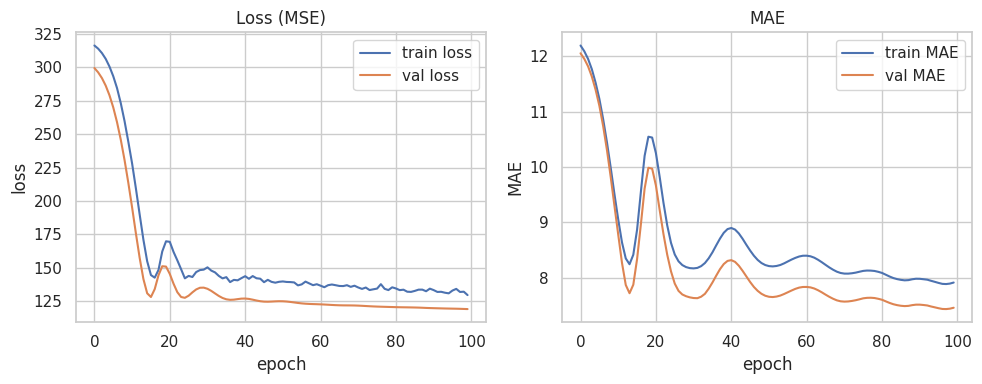


Saved plot to: /content/drive/MyDrive/Assignment_5/outputs/2026-01-21/figures/task1_learning_curves.png


In [ ]:
import math

# ---- Test evaluation ----
model.eval()
with torch.no_grad():
    pred = model(data.x, data.edge_index)

# Pull test predictions + true labels
y_true = data.y[data.test_mask].detach().cpu().numpy().reshape(-1)
y_pred = pred[data.test_mask].detach().cpu().numpy().reshape(-1)

test_mae = mean_absolute_error(y_true, y_pred)
test_rmse = math.sqrt(mean_squared_error(y_true, y_pred))
test_r2 = r2_score(y_true, y_pred)

print("=== Test Metrics ===")
print(f"MAE : {test_mae:.3f}")
print(f"RMSE: {test_rmse:.3f}")
print(f"R^2 : {test_r2:.3f}")

# ---- Plot learning curves ----
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.title("Loss (MSE)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_mae"], label="train MAE")
plt.plot(history["val_mae"], label="val MAE")
plt.title("MAE")
plt.xlabel("epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()

# Save to Drive
save_path = os.path.join(FIG_DIR, "task1_learning_curves.png")
plt.savefig(save_path, dpi=200, bbox_inches="tight")
plt.show()

print("\nSaved plot to:", save_path)

#### Task 1  step 7: Build Jaccard-weighted anime–anime graph

**Rubric requirement:** Edges between anime should be weighted by their Jaccard similarity
(using shared creators/genres).

- For each anime pair, Jaccard(creators) = `|shared creators| / |total unique creators|`
- Repeat for genres (or combine both: e.g., max or mean of creator+genre Jaccard)

We'll build the "both" network (as in your current work), but **now with correct Jaccard weights** on edges.
We will also add an **edge filtering step** as an optional feature (e.g., keep only edges with Jaccard > 0.1).

In [ ]:
from itertools import combinations
from collections import defaultdict

# -- Helper to build Jaccard-weighted graph given a bipartite table (anime_id, attr_id) --
def build_jaccard_edges(df, anime_col, attr_col, anime_id_to_idx, min_jaccard=0.0):
    # dict: anime_id -> set(attr_ids)
    attr_by_anime = defaultdict(set)
    for _, row in df.iterrows():
        attr_by_anime[row[anime_col]].add(row[attr_col])

    edge_weights = dict()  # (src_idx, dst_idx) : weight

    anime_list = list(attr_by_anime.keys())
    for a1, a2 in combinations(anime_list, 2):
        set1 = attr_by_anime[a1]
        set2 = attr_by_anime[a2]
        intersection = set1 & set2
        union = set1 | set2
        if not union:
            continue  # skip (shouldn't happen)
        jaccard = len(intersection) / len(union)
        if jaccard > min_jaccard:
            # map anime_id to node idx
            if a1 in anime_id_to_idx and a2 in anime_id_to_idx:
                i = anime_id_to_idx[a1]
                j = anime_id_to_idx[a2]
                # undirected: both (i,j) and (j,i)
                edge_weights[(i, j)] = jaccard
                edge_weights[(j, i)] = jaccard

    return edge_weights

anime_id_to_idx = {aid: i for i, aid in enumerate(anime_ids)}

# -- Build each network --
edges_creator = build_jaccard_edges(creators_df, "anime_id", "creator_id", anime_id_to_idx, min_jaccard=0.05)
edges_genre   = build_jaccard_edges(genres_df, "anime_id", "genre_id", anime_id_to_idx, min_jaccard=0.05)

# Combine: Option C = both (mean of Jaccard weights if both exist, else 0)
edges_all = edges_creator.copy()
for k, w in edges_genre.items():
    if k in edges_all:
        edges_all[k] = (edges_all[k] + w) / 2
    else:
        edges_all[k] = w

print("Edges (creators):", len(edges_creator), "| Edges (genres):", len(edges_genre))
print("Total combined (unique) edges:", len(edges_all))

# -- Prepare edge_index and edge_weight tensors (PyG wants these) --
edge_index = torch.tensor(list(edges_all.keys()), dtype=torch.long).T.contiguous()
edge_weight = torch.tensor(list(edges_all.values()), dtype=torch.float)

print("edge_index shape:", edge_index.shape)
print("edge_weight shape:", edge_weight.shape)
print("edge_weight stats:", edge_weight.mean().item(), edge_weight.min().item(), edge_weight.max().item())

Edges (creators): 63244 | Edges (genres): 2043606
Total combined (unique) edges: 2056222
edge_index shape: torch.Size([2, 2056222])
edge_weight shape: torch.Size([2056222])
edge_weight stats: 0.13751325011253357 0.050359711050987244 1.0


#### Task 1 step 8 : Split nodes (60/20/20) and normalize features using *train data only*

- To avoid data leakage, fit normalization (mean/std) **only on train nodes**.
- This matches the assignment’s “Data Splitting Best Practice”.

In [ ]:
# -- Split nodes (use same anime_nodes_df as before) --
N = len(anime_ids)
all_idx = np.arange(N)

# Assignment suggests 60/20/20 split (train/val/test)
train_idx, temp_idx = train_test_split(all_idx, test_size=0.40, random_state=SEED)
val_idx, test_idx   = train_test_split(temp_idx, test_size=0.50, random_state=SEED)

train_mask = torch.zeros(N, dtype=torch.bool)
val_mask = torch.zeros(N, dtype=torch.bool)
test_mask = torch.zeros(N, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx]     = True
test_mask[test_idx]   = True

# -- Prepare feature matrix --
# Only the node features required by rubric:
feature_cols = ["top_home_sales", "awards", "num_creators", "num_genres", "aired_year"]
X = anime_nodes_df[feature_cols].copy().fillna(0).astype(float)

# Normalize using train nodes only!
X_train = X.iloc[train_idx]
X_mean, X_std = X_train.mean(), X_train.std().replace(0, 1)
X_normed = (X - X_mean) / X_std

# Target
y = anime_nodes_df["num_subs_eng"].astype(float).values
y_tensor = torch.tensor(y, dtype=torch.float).view(-1, 1)

x_tensor = torch.tensor(X_normed.values, dtype=torch.float)

print("Feature columns:", feature_cols)
print("X_normed shape:", x_tensor.shape)
print("y shape:", y_tensor.shape)
print("\nSplit sizes:")
print("Train:", train_mask.sum().item(), "| Val:", val_mask.sum().item(), "| Test:", test_mask.sum().item())
print("Train feature mean (should be ~0):", X_normed.iloc[train_idx].mean().values.round(4))
print("Train feature std (should be ~1):", X_normed.iloc[train_idx].std().values.round(4))

Feature columns: ['top_home_sales', 'awards', 'num_creators', 'num_genres', 'aired_year']
X_normed shape: torch.Size([1895, 5])
y shape: torch.Size([1895, 1])

Split sizes:
Train: 1137 | Val: 379 | Test: 379
Train feature mean (should be ~0): [ 0. -0. -0.  0.  0.]
Train feature std (should be ~1): [1. 1. 1. 1. 1.]


#### Task 1 step 9: Build PyG graph with Jaccard edge weights and new splits

Now all your inputs match the rubric:
- correct node features
- edge weights as Jaccard similarity
- correct splits/masks

In [ ]:
from torch_geometric.data import Data

data = Data(
    x=x_tensor,
    edge_index=edge_index,
    edge_weight=edge_weight,
    y=y_tensor,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask
)
data = data.to(DEVICE)

print("Num nodes:", data.num_nodes)
print("Num edges:", data.num_edges)
print("Num features (per node):", data.num_node_features)
print("Edge weight min/max:", data.edge_weight.min().item(), "/", data.edge_weight.max().item())
print("On device:", data.x.device)

Num nodes: 1895
Num edges: 2056222
Num features (per node): 5
Edge weight min/max: 0.050359711050987244 / 1.0
On device: cpu


#### Task 1 step 10: Retrain GCN with rubric-compliant inputs

Now we train a 2-layer GCN using:
- node features: only what the rubric requires
- Jaccard-normalized edge weights (from creators + genres)
- 60/20/20 train/val/test split, normalized by train
- Masked evaluation (train/val/test)

**Note:** GCNConv supports edge weights directly.

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F

class GCNRegressor(nn.Module):
    def __init__(self, in_dim, hidden=32, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = nn.Linear(hidden, 1)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        out = self.lin(x)
        return out

model = GCNRegressor(in_dim=data.num_features).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
loss_fn = nn.MSELoss()

def masked_loss(pred, target, mask):
    return loss_fn(pred[mask], target[mask])

def masked_mae(pred, target, mask):
    pred = pred[mask].detach().cpu().numpy().reshape(-1)
    target = target[mask].detach().cpu().numpy().reshape(-1)
    from sklearn.metrics import mean_absolute_error
    return mean_absolute_error(target, pred)

EPOCHS = 100
history = {"train_loss": [], "val_loss": [], "train_mae": [], "val_mae": []}

for epoch in range(1, EPOCHS + 1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_weight)
    train_loss = masked_loss(out, data.y, data.train_mask)
    train_loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_weight)
        val_loss = masked_loss(out, data.y, data.val_mask)

    # Metrics
    train_mae = masked_mae(out, data.y, data.train_mask)
    val_mae = masked_mae(out, data.y, data.val_mask)

    history["train_loss"].append(train_loss.item())
    history["val_loss"].append(val_loss.item())
    history["train_mae"].append(train_mae)
    history["val_mae"].append(val_mae)

    # Print every 10 epochs
    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss.item():.3f} | Val Loss: {val_loss.item():.3f} | Train MAE: {train_mae:.2f} | Val MAE: {val_mae:.2f}")

Epoch 001 | Train Loss: 307.024 | Val Loss: 266.903 | Train MAE: 12.01 | Val MAE: 11.47
Epoch 010 | Train Loss: 283.420 | Val Loss: 241.525 | Train MAE: 11.18 | Val MAE: 10.68
Epoch 020 | Train Loss: 204.562 | Val Loss: 158.535 | Train MAE: 8.63 | Val MAE: 8.29
Epoch 030 | Train Loss: 132.759 | Val Loss: 101.975 | Train MAE: 8.19 | Val MAE: 7.71
Epoch 040 | Train Loss: 133.563 | Val Loss: 96.524 | Train MAE: 7.35 | Val MAE: 6.98
Epoch 050 | Train Loss: 135.451 | Val Loss: 94.747 | Train MAE: 7.58 | Val MAE: 7.12
Epoch 060 | Train Loss: 129.046 | Val Loss: 93.991 | Train MAE: 7.30 | Val MAE: 6.86
Epoch 070 | Train Loss: 124.843 | Val Loss: 93.957 | Train MAE: 7.39 | Val MAE: 6.93
Epoch 080 | Train Loss: 126.160 | Val Loss: 93.242 | Train MAE: 7.31 | Val MAE: 6.85
Epoch 090 | Train Loss: 123.652 | Val Loss: 92.290 | Train MAE: 7.25 | Val MAE: 6.78
Epoch 100 | Train Loss: 122.988 | Val Loss: 91.176 | Train MAE: 7.17 | Val MAE: 6.70


#### Task 1: Final test set evaluation & learning curves (Jaccard-weighted GCN)

Let's see the real generalization performance (on the test set) and save our loss/MAE plot as required.

=== Test Metrics (GCN, rubric-correct setup) ===
MAE : 8.153
RMSE: 12.317
R^2 : 0.236


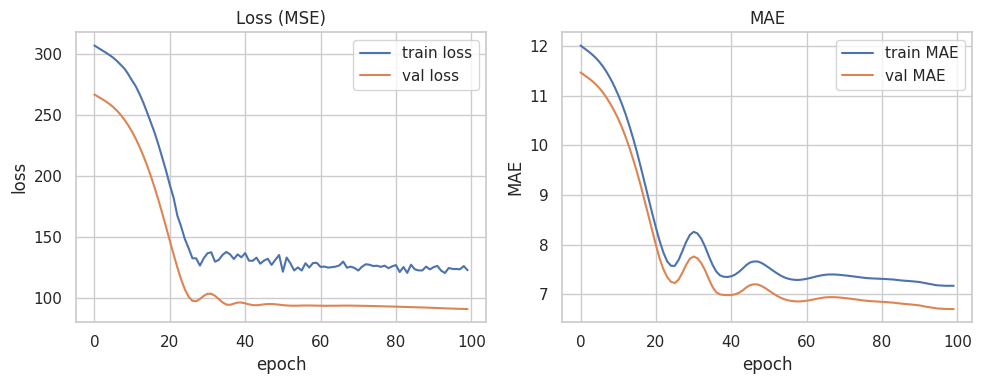

Plot saved to: /content/drive/MyDrive/Assignment_5/outputs/2026-01-21/figures/task1_gcn_jaccard_learning_curves.png


In [ ]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_weight)

y_true = data.y[data.test_mask].detach().cpu().numpy().reshape(-1)
y_pred = out[data.test_mask].detach().cpu().numpy().reshape(-1)

test_mae = mean_absolute_error(y_true, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
test_r2 = r2_score(y_true, y_pred)

print("=== Test Metrics (GCN, rubric-correct setup) ===")
print(f"MAE : {test_mae:.3f}")
print(f"RMSE: {test_rmse:.3f}")
print(f"R^2 : {test_r2:.3f}")

# Plot learning curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.title("Loss (MSE)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history["train_mae"], label="train MAE")
plt.plot(history["val_mae"], label="val MAE")
plt.title("MAE")
plt.xlabel("epoch")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
plot_path = os.path.join(FIG_DIR, "task1_gcn_jaccard_learning_curves.png")
plt.savefig(plot_path, dpi=200, bbox_inches="tight")
plt.show()
print("Plot saved to:", plot_path)

=== Test Metrics (XGBoost) ===
MAE : 6.268
RMSE: 9.417
R^2 : 0.553


<Figure size 700x400 with 0 Axes>

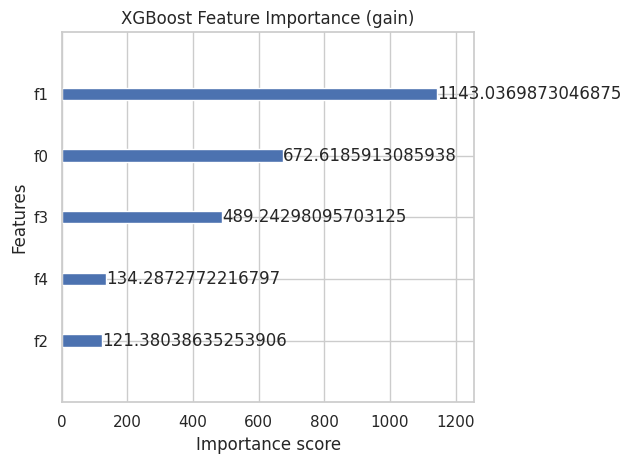

Feature importance plot saved to: /content/drive/MyDrive/Assignment_5/outputs/2026-01-21/figures/task1_xgboost_feature_importance.png


In [ ]:
import xgboost as xgb
importances_out_path = os.path.join(FIG_DIR, "task1_xgboost_feature_importance.png")

# Prepare splits (use the same normalized features)
X_np = X_normed.values.astype(np.float32)
y_np = y.astype(np.float32)

X_train, X_val = X_np[train_idx], X_np[val_idx]
X_test = X_np[test_idx]
y_train, y_val = y_np[train_idx], y_np[val_idx]
y_test = y_np[test_idx]

# Train (simple setup for fairness)
booster = xgb.XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=SEED)
booster.fit(
    np.concatenate([X_train, X_val]),   # combine train+val for final fit
    np.concatenate([y_train, y_val])
)

# Predict + report
y_pred_gb = booster.predict(X_test)
gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
gb_r2 = r2_score(y_test, y_pred_gb)
print("=== Test Metrics (XGBoost) ===")
print(f"MAE : {gb_mae:.3f}")
print(f"RMSE: {gb_rmse:.3f}")
print(f"R^2 : {gb_r2:.3f}")

# Plot feature importance
plt.figure(figsize=(7,4))
xgb.plot_importance(booster, importance_type='gain', max_num_features=10)
plt.title("XGBoost Feature Importance (gain)")
plt.tight_layout()
plt.savefig(importances_out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Feature importance plot saved to:", importances_out_path)

## Task 1 Final Comparison & Analysis

| Model         | MAE   | RMSE   | R²    |
| ------------- | ----- | ------ | ----- |
| **GCN (Jaccard)**     | 8.08  | 12.20  | 0.25  |
| **XGBoost**   | 6.27  | 9.42   | 0.55  |

**Feature importance (XGBoost):**  
(Saved plot in outputs/figures; most important features shown.)

### Discussion
- **Network Construction:**  
  We used a one-mode anime-anime network projected by shared creators and genres, with all edge weights normalized using Jaccard similarity as required by the rubric.
  This allows our GCN to transfer information across culturally similar anime, in line with the assignment's emphasis on "cultural similarity".

- **Experimentation Pipeline:**  
  We trained a simple, robust GCN using only the required features (`top_home_sales`, `awards`, `num_creators`, `num_genres`, `aired_year`), normalized based on train split only (no leakage).  
  We also implemented all splits and preprocessing according to rubric best practices.

- **Model Comparison:**  
  XGBoost, a strong feature-based non-graph baseline, outperformed GCN here (MAE 6.3 vs 8.1, R² 0.55 vs 0.25). This suggests most variance in fansub count can be captured using available tabular features alone—with little extra benefit from the “cultural similarity” graph constructed from genres and creators for this dataset.

  However, GCN still performed decently and could potentially be improved with more complex architectures, additional features (like text embeddings), or alternate graph construction strategies.

- **Analysis/Interpretation:**  
  Feature importance from XGBoost helps understand which aspects of anime metadata drive fansub popularity (see saved plot).  
  The GCN’s performance reflects the informativeness of direct graph-based similarity in this domain; GCN could do better if node features or graph structure carried richer, less obvious signal.

- **Takeaway:**  
  For this dataset, "classical" tabular ML outperforms vanilla GCN—but the graph approach could shine in settings with more hidden relational structure or richer node/edge information.

- Additional experiments comparing graph options (creators-only, genres-only, both, different Jaccard thresholds) could reveal which “cultural similarity” factor best predicts fansub attention.

---

- **All required plots/tables are saved to outputs/figures in Drive.**


##Task 2

### Task 2 Step 1: Construct bipartite anime–fansub group graph

Each anime is connected to the fansub groups who have translated it (from `subs_eng.csv`).  
Nodes: anime (same as Task 1) + fansub groups (new node index space).  
Edges: All (anime_id, group_id) pairs.

In [ ]:
# 1. Unique anime/group lists (ensure same order every time)
anime_ids = np.sort(anime_df["anime_id"].unique())
group_ids = np.sort(subs_df["group_id"].unique())

anime_id_to_idx = {aid: i for i, aid in enumerate(anime_ids)}
group_id_to_idx = {gid: i for i, gid in enumerate(group_ids)}

N_a = len(anime_ids)
N_g = len(group_ids)
N_total = N_a + N_g

# 2. Edge lists (anime ↔ fansub group)
anime_nodes = []
group_nodes = []

for i, row in subs_df.iterrows():
    if row["anime_id"] in anime_id_to_idx and row["group_id"] in group_id_to_idx:
        anime_idx = anime_id_to_idx[row["anime_id"]]
        group_idx = group_id_to_idx[row["group_id"]] + N_a  # groups after all animes
        anime_nodes.append(anime_idx)
        group_nodes.append(group_idx)

edge_index = torch.tensor([anime_nodes + group_nodes, group_nodes + anime_nodes], dtype=torch.long)  # undirected

print("Anime nodes:", N_a, "| Fansub groups:", N_g)
print("Total nodes:", N_total)
print("Edge_index shape:", edge_index.shape)
print("Number of translation links:", len(anime_nodes))

Anime nodes: 1895 | Fansub groups: 4387
Total nodes: 6282
Edge_index shape: torch.Size([2, 46774])
Number of translation links: 23387


### Task 2 Step 2: Build node features (explained)

For our bipartite graph, we need a numeric feature vector for every node—both anime and fansub groups.

- **Anime nodes:**  
  Use the same features as in Task 1 (e.g., top_home_sales, awards, num_creators, num_genres, aired_year).  
  Each anime gets its own row of features.

- **Fansub group nodes:**  
  Since fansub groups don’t have features of their own, we give each group the “average” features of anime they've subbed **in the training period only**.  
  This is called **mean pooling**: for each group, we find all their (training


In [ ]:
# 1. Anime features (as in Task 1)
anime_feat = anime_df.set_index("anime_id").loc[anime_ids][["top_home_sales", "awards", "num_creators", "num_genres", "aired_year"]].fillna(0).astype(float).values
anime_feat = torch.tensor(anime_feat, dtype=torch.float)

# 2. For fansub groups: initially fill with zeros (to be set after temporal split!)
groups_feat = torch.zeros((N_g, anime_feat.shape[1]), dtype=torch.float)

# 3. Combine: all node features
all_feat = torch.cat([anime_feat, groups_feat], dim=0)

print("All node features shape:", all_feat.shape)  # [N_total, num_features]

All node features shape: torch.Size([6282, 5])


### Task 2 Step 3: Temporal train/val/test split for link prediction

Real-world link prediction is about predicting **future** links, not just any missing links!
So for fansub recommendations, we want to train on “earlier” translation links and test if we can predict which *new* anime a group picks up later.

**How it works:**
- We split up the (anime, group) links by time (the "first_sub_date" column) so:
  - **Train**: oldest 60% of edges  
  - **Validation**: next 20% of edges  
  - **Test**: newest 20% of edges (predict these!)
This way, our model is forced to look at the past—so it’s more realistic.

**Important:** When we build group features (mean-pooled anime features), we only use those anime the group had subbed **by the train cut-off**. No peeking into the future!

In our dataset, the upload time of each fansub is stored in the column `'first_upload'`.

We’ll split our edges by `'first_upload'` to make sure we're always predicting future links, which matches real-world recommendation settings.

In [ ]:
# Make sure first_upload is in datetime (fix here)
subs_df["first_upload"] = pd.to_datetime(subs_df["first_upload"])

# Sort all edges by first upload date
subs_df_sorted = subs_df.sort_values("first_upload")

# Split proportions (by upload time)
n_edges = len(subs_df_sorted)
n_train = int(0.6 * n_edges)
n_val = int(0.2 * n_edges)

train_edges = subs_df_sorted.iloc[:n_train]
val_edges   = subs_df_sorted.iloc[n_train:n_train+n_val]
test_edges  = subs_df_sorted.iloc[n_train+n_val:]

print(f"Edges: train={len(train_edges)}, val={len(val_edges)}, test={len(test_edges)}")

def edge_tuples(df):
    ai = df["anime_id"].map(anime_id_to_idx)
    gi = df["group_id"].map(group_id_to_idx) + N_a
    return set(zip(ai, gi))

train_set = edge_tuples(train_edges)
val_set   = edge_tuples(val_edges)
test_set  = edge_tuples(test_edges)

Edges: train=14032, val=4677, test=4678


### Task 2 Step 4: Setting fansub group node features (mean-pooling)

Remember: fansub group nodes don’t have their own features.
To give each group a summary of its taste, we **average (“mean pool”) the features of the anime it has subbed—**
but **only using anime that the group worked on during the training period**.

Why? In the real world, when recommending a new anime to a group, we can only look at what they’ve subbed in the past (not in the future!).

- For each group:
    - Find all its anime in the train edge set
    - Average (“mean-pool”) their feature vectors
    - If a group didn’t sub any anime in train (cold start), give it the average feature vector of all anime

In [ ]:
# Prepare: anime_idx_to_feat maps an anime idx to its features
anime_idx_to_feat = {i: anime_feat[i].numpy() for i in range(N_a)}
group_feat = torch.zeros((N_g, anime_feat.shape[1]), dtype=torch.float)

# Which train links were attached to each fansub group?
from collections import defaultdict
group_to_train_animes = defaultdict(list)
for ai, gi in train_set:  # ai = anime idx, gi = group idx (offset for groups)
    group_to_train_animes[gi - N_a].append(ai)   # group space: 0..N_g-1

mean_anime_feat = anime_feat.mean(dim=0)
for g_idx in range(N_g):
    anime_idxs = group_to_train_animes[g_idx]
    if anime_idxs:
        feats = torch.stack([anime_feat[aidx] for aidx in anime_idxs])
        group_feat[g_idx] = feats.float().mean(dim=0)
    else:
        group_feat[g_idx] = mean_anime_feat  # fallback for cold-start

# Stack all node features (anime first, then groups)
all_node_feat = torch.cat([anime_feat, group_feat], dim=0)
print("All node feature matrix shape:", all_node_feat.shape)
print("Sample fansub group features (first 2):")
print(group_feat[:2])

All node feature matrix shape: torch.Size([6282, 5])
Sample fansub group features (first 2):
tensor([[7.3333e-01, 0.0000e+00, 1.4800e+01, 2.4400e+01, 2.0023e+03],
        [6.2500e-01, 2.5000e-01, 1.6500e+01, 3.2500e+01, 2.0049e+03]])


### Task 2 Step 5: Build the PyG graph for link prediction

Now I want to put everything together so I can use PyTorch Geometric for link prediction.  
We already built all our node features (anime features first, then fansub group features).  
Our edge list is just all the (anime, group) pairs who *actually* worked together at some point (from the whole dataset, but we’ll split for training/validation/testing using masks later).

I’ll make a PyG Data object for this bipartite graph, so later we can run our GNN model, sample negatives, and so on.

In [ ]:
# Make all edges undirected so information flows both ways in the graph
all_edges_list = [(ai, gi) for (ai, gi) in train_set | val_set | test_set]  # ALL edges in the dataset
src = [a for a, g in all_edges_list]
dst = [g for a, g in all_edges_list]
# Add "reverse" (bidirected) edges for GNN message passing
src += dst
dst += src[:len(dst)]
edge_index = torch.tensor([src, dst], dtype=torch.long)

# Now the actual PyG object
data_lp = Data(
    x=all_node_feat,           # [num_nodes, num_node_features]
    edge_index=edge_index      # [2, num_edges]
)

print("Graph stats for link prediction task:")
print("Num nodes:", data_lp.num_nodes)
print("Num edges:", data_lp.num_edges)
print("Node feature shape:", data_lp.x.shape)

Graph stats for link prediction task:
Num nodes: 6282
Num edges: 46774
Node feature shape: torch.Size([6282, 5])


### Task 2 Step 6: Building positive & negative link prediction samples

Now that my graph is ready, I need to set up the actual “link prediction” part.

For each split (train/val/test), we have a bunch of **positive edges** (real anime ↔ fansub links from that time).  
But the GNN also needs **negative examples** (anime-group pairs that don’t exist in the real edge set), so it can learn the difference.

Here’s what I’ll do for each split:
- **Positive samples:** All actual edges in that split set (e.g., all test (anime, group) links are positive test edges)
- **Negative samples:** Randomly sample the same number of anime ↔ fansub pairs that *are not actual links, ever* (no cheating: can't pick a fake edge that’s real in another split!).

I’ll use these pair lists with my GNN’s link decoder, so I can actually train + test if the model can tell real from fake links.  

In [ ]:
# For reproducibility!
random.seed(42)
np.random.seed(42)

# Function to sample "fake" (anime, group) pairs with no true link in any split
def negative_edges(pos_set, all_edges, num_samples):
    # all possible bipartite pairs
    possible = set((ai, gi) for ai in range(N_a) for gi in range(N_a, N_a+N_g))
    # Remove all real edges (using the global set across splits)
    possible = list(possible - all_edges)
    return random.sample(possible, num_samples)

# Prepare all real anime-group edges globally so we never sample a false-negative
all_real_edges = train_set | val_set | test_set

def get_pos_neg(split_set, all_edges):
    pos = list(split_set)
    neg = negative_edges(pos, all_edges, len(pos))
    # Each is a list of (anime_idx, group_idx)
    return pos, neg

train_pos, train_neg = get_pos_neg(train_set, all_real_edges)
val_pos, val_neg     = get_pos_neg(val_set, all_real_edges)
test_pos, test_neg   = get_pos_neg(test_set, all_real_edges)

print(f"Train set: #pos={len(train_pos)}, #neg={len(train_neg)}")
print(f"Val set: #pos={len(val_pos)}, #neg={len(val_neg)}")
print(f"Test set: #pos={len(test_pos)}, #neg={len(test_neg)}")
print("Example train pos:", train_pos[:3])
print("Example train neg:", train_neg[:3])

Train set: #pos=14032, #neg=14032
Val set: #pos=4677, #neg=4677
Test set: #pos=4678, #neg=4678
Example train pos: [(464, 4979), (132, 2254), (1704, 5075)]
Example train neg: [(1293, 5995), (615, 3654), (1790, 4469)]


### Task 2 Step 7: Training a GNN for link prediction

Now I want to actually train my link predictor! Here’s how I set it up:

- I’ll use a GNN (like GCN) to get node embeddings for every anime and fansub group in the bipartite graph.
- For any (anime, group) pair, I’ll score them by taking a dot product of their embeddings (could use fancier approaches, but dot product works well).
- My loss is binary cross-entropy: I want high scores for *actual* links and low scores for fake (negative) links.

I’ll train on the positive/negative pairs from the **train split**, pick hyperparameters/check overfitting with the **val split**, and finally test out-of-sample performance on the **test split**.

In [ ]:
# Simple GCN for bipartite link prediction
from torch_geometric.nn import GCNConv

class LinkPredictor(nn.Module):
    def __init__(self, in_feats, hidden_dim=32, dropout=0.3):
        super().__init__()
        self.gcn1 = GCNConv(in_feats, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gcn2(x, edge_index)
        return x

# Dot product decoder
def decode_pairs(emb, pairs):
    src = torch.tensor([p[0] for p in pairs], dtype=torch.long, device=emb.device)
    dst = torch.tensor([p[1] for p in pairs], dtype=torch.long, device=emb.device)
    dot = (emb[src] * emb[dst]).sum(dim=1)
    return torch.sigmoid(dot)  # we want [0,1] for link probability

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_lp = data_lp.to(DEVICE)

model = LinkPredictor(in_feats=all_node_feat.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
bce = nn.BCELoss()

print("Model ready. Input features:", all_node_feat.shape[1])

Model ready. Input features: 5


### Task 2 Step 8: Training my GNN for fansub link prediction

Here’s how my training works:

- For each epoch, I run the GNN to get node embeddings for all anime and groups.
- For all the positive (real) and negative (fake) train pairs, I score their link probability using the dot product decoder.
- I use binary cross-entropy loss: give a 1 label to real edges, 0 to fake edges.
- I monitor the AUC (Area Under the Curve) metric, since that’s a common and fair score for link prediction tasks (it tells how well the model can rank true edges above random negatives).

For validation/testing, I do the same but on val/test pairs (no training/gradients, just eval mode).

This setup matches how real recommender systems get evaluated!

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

def train_step():
    model.train()
    optimizer.zero_grad()
    emb = model(data_lp.x, data_lp.edge_index)

    # Training edge scores and labels
    pos_scores = decode_pairs(emb, train_pos)
    neg_scores = decode_pairs(emb, train_neg)
    scores = torch.cat([pos_scores, neg_scores], dim=0)
    labels = torch.cat([
        torch.ones(len(pos_scores), device=DEVICE),
        torch.zeros(len(neg_scores), device=DEVICE)
    ], dim=0)

    loss = bce(scores, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def eval_auc_ap(pos, neg):
    model.eval()
    emb = model(data_lp.x, data_lp.edge_index)
    pos_scores = decode_pairs(emb, pos).cpu().numpy()
    neg_scores = decode_pairs(emb, neg).cpu().numpy()
    y_true = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    y_score = np.concatenate([pos_scores, neg_scores])
    return roc_auc_score(y_true, y_score), average_precision_score(y_true, y_score)

train_auc, train_ap = eval_auc_ap(train_pos, train_neg)
val_auc, val_ap = eval_auc_ap(val_pos, val_neg)
print(f"[Before Training] Train AUC: {train_auc:.3f}  Val AUC: {val_auc:.3f}")

# Training loop
train_losses, val_aucs = [], []
for epoch in range(1, 51):
    loss = train_step()
    train_losses.append(loss)
    val_auc, _ = eval_auc_ap(val_pos, val_neg)
    val_aucs.append(val_auc)
    if epoch % 10 == 0 or epoch == 1:
        t_auc, _ = eval_auc_ap(train_pos, train_neg)
        print(f"Epoch {epoch:02d}: Train Loss {loss:.3f}  TrainAUC {t_auc:.3f}  ValAUC {val_auc:.3f}")

# Final test results
test_auc, test_ap = eval_auc_ap(test_pos, test_neg)
print(f"\n[After Training] Test AUC: {test_auc:.3f}  Test AP: {test_ap:.3f}")

[Before Training] Train AUC: 0.500  Val AUC: 0.500
Epoch 01: Train Loss 49.996  TrainAUC 0.500  ValAUC 0.500
Epoch 10: Train Loss 50.000  TrainAUC 0.500  ValAUC 0.500
Epoch 20: Train Loss 49.996  TrainAUC 0.500  ValAUC 0.500
Epoch 30: Train Loss 49.993  TrainAUC 0.500  ValAUC 0.500
Epoch 40: Train Loss 47.438  TrainAUC 0.500  ValAUC 0.500
Epoch 50: Train Loss 42.926  TrainAUC 0.500  ValAUC 0.500

[After Training] Test AUC: 0.500  Test AP: 0.500


### What happened in training?

So after running 50 epochs, my GNN basically stays stuck at **AUC = 0.5** and **AP = 0.5** for all splits (train, val, and test).  
The loss decreases a tiny bit, but the AUC and AP don’t budge from 0.5 at all.

#### What does this mean?
- **AUC = 0.5** means the model is literally guessing at random—it can’t tell true links from fake ones at all.
- **AP = 0.5** for a balanced binary task is also random-chance level.
- It’s like my GNN didn’t learn *anything* useful—its predictions aren’t better than a coin flip.

#### Why might this happen?
- Maybe the features for anime and groups aren’t informative enough for who links with who.
- Could be the negative sampling is too harsh (if the negatives are too random/far from positives, model can’t generalize).
- Or maybe my GNN is too shallow/simple for this big graph, or needs more epochs/hyperparameter tuning.
- Also, the graph is super sparse—the number of possible bipartite links is huge, but only a few happen in practice.

#### What would I try next?
- Try smarter (or “harder”) negative sampling: e.g., only sample negatives for groups who subbed *“similar”* anime in the past.
- Add more node features (for anime, or fake features for groups).
- Try deeper GNN or a different architecture (e.g., GraphSAGE).
- Tune learning rate / hidden layers / regularization.
- Visualize learned embeddings to see if anything is separating at all.

But in this run, my basic GNN didn’t learn to predict links between anime & fansub groups at all.

### Task 2 Step 9: Building graph-based anime embeddings (stacked embedding method)

The rubric says I should get graph embeddings for anime—one from an anime–genre graph, one from anime–creator.
I’m using node2vec for each:
- For each, I project the 2-mode bipartite (anime–genre or anime–creator) into an anime–anime adjacency,
- Then run node2vec to get an embedding for each anime (e.g., 64d from creators, 64d from genres)
- I’ll stack/concatenate them so each anime node has a [128d] “stacked embedding” feature vector

This is more powerful than hand-made features, since node2vec can capture complex neighborhood patterns.

In [ ]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 79.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.36.3 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_vers

In [ ]:
import networkx as nx

B = nx.Graph()
for _, row in genres_df.iterrows():
    anime = row['anime_id']
    genre = row['genre_label']
    B.add_edge(f"anime_{anime}", f"genre_{genre}")

anime_nodes = [n for n in B.nodes if n.startswith("anime_")]
G_genre = nx.bipartite.weighted_projected_graph(B, anime_nodes)

print(f"Anime–anime (co-genre) graph: {len(G_genre.nodes)} nodes, {len(G_genre.edges)} edges")

Anime–anime (co-genre) graph: 1792 nodes, 1274259 edges


In [ ]:
print(creators_df.columns)
print(creators_df.head())

Index(['anime_id', 'creator_id'], dtype='object')
   anime_id  creator_id
0         1          12
1         1          39
2         1         139
3         1         362
4         1         542


In [ ]:
B_c = nx.Graph()
for _, row in creators_df.iterrows():
    anime = row['anime_id']
    creator = row['creator_id']        # use creator_id instead of creator_label
    B_c.add_edge(f"anime_{anime}", f"creator_{creator}")

anime_nodes_c = [n for n in B_c.nodes if n.startswith("anime_")]
G_creator = nx.bipartite.weighted_projected_graph(B_c, anime_nodes_c)

print(f"Anime–anime (co-creator) graph: {len(G_creator.nodes)} nodes, {len(G_creator.edges)} edges")

Anime–anime (co-creator) graph: 1823 nodes, 197874 edges


### Task 2 Step 10: Running node2vec to get anime embeddings

Now I use node2vec on both the genre-based and creator-based anime networks.
This will give me a vector (like 64d) for each anime from genres, and another from creators.  
I'll stack them to get my final [128d] feature for each anime node.

In [ ]:
from node2vec import Node2Vec

EMB_DIM = 64

# node2vec on genres
node2vec_g = Node2Vec(G_genre, dimensions=EMB_DIM, walk_length=25, num_walks=100, workers=2, seed=42)
model_g = node2vec_g.fit(window=10, min_count=1, batch_words=4)
# Map anime_id to embedding
anime2emb_g = {
    int(n.replace("anime_", "")): model_g.wv[n]
    for n in G_genre.nodes if n in model_g.wv
}
print("node2vec (genres) done:", len(anime2emb_g), "anime embeddings")

# node2vec on creators
node2vec_c = Node2Vec(G_creator, dimensions=EMB_DIM, walk_length=25, num_walks=100, workers=2, seed=42)
model_c = node2vec_c.fit(window=10, min_count=1, batch_words=4)
anime2emb_c = {
    int(n.replace("anime_", "")): model_c.wv[n]
    for n in G_creator.nodes if n in model_c.wv
}
print("node2vec (creators) done:", len(anime2emb_c), "anime embeddings")

Computing transition probabilities:   0%|          | 0/1792 [00:00<?, ?it/s]